# Kernel Functions and Derivatives

In [4]:
import sys
sys.path.insert(0,'/home/emmanuel/projects/2019_sakame/src')

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from data.make_dataset import ToyData
from models.gp_demo import DemoGP
from models.derivatives import RBFDerivative

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


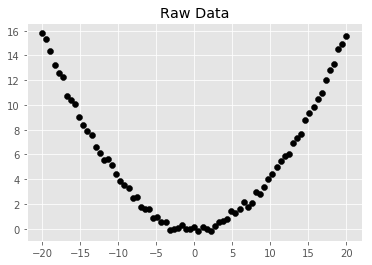

In [6]:
num_points = 500
noise = 0.2
num_points = 75
func = 'poly'
degree = 2
random_state = 123

x = np.linspace(-20, 20, num_points)

y = ToyData().regress_f(
    x,
    func=func,
    noise=noise,
    degree=degree,
    random_state=random_state
)

fig, ax = plt.subplots()

ax.scatter(x, y, color='Black')
ax.set_title('Raw Data')
plt.show()

## RBF Derivative

#### Pythonic

In [ ]:
def rbf_derivative(x_train, x_function, weights, kernel_mat,
                   n_derivative=1, length_scale=1.0):
    """This function calculates the rbf derivative
    Parameters
    ----------
    X_train : array, [N x D]

    X_test  : array, [M x D]

    weights   : array, [N x D]

    kernel: array, [N x M]

    n_derivative : int, (default = 1) {1, 2}
        calculates nth derivative
    
    gamma : float, default: None

    Returns
    -------
    
    derivative : array, [M x D]

    Information
    -----------
    Author: Juan Emmanuel Johnson
    Email : jej2744@rit.edu
            juan.johnson@uv.es
    """

    # initialize rbf kernel
    derivative = np.zeros(np.shape(x_function))

    # get all of the parameters
    theta = - 1 / length_scale**2

    if n_derivative == 1:

        # loop through dimensions
        for dim in np.arange(0, np.shape(x_function)[1]):

            # loop through the number of test points
            for iTest in np.arange(0, np.shape(x_function)[0]):

                # loop through the number of test points
                for iTrain in np.arange(0, np.shape(x_train)[0]):

                    derivative[iTest, dim] += theta * weights[iTrain] * \
                                              (x_train[iTrain, dim] -
                                               x_function[iTest, dim]) * \
                                              kernel_mat[iTrain, iTest]


    elif n_derivative == 2:

        # loop through dimensions
        for dim in np.arange(0, np.shape(x_function)[1]):

            # loop through the number of test points
            for iTest in np.arange(0, np.shape(x_function)[0]):

                # loop through the number of test points
                for iTrain in np.arange(0, np.shape(x_train)[0]):

                    derivative[iTest, dim] += weights[iTrain] * \
                                                      (theta**2 *
                                                       (x_train[iTrain, dim] - x_function[iTest, dim])**2
                                                       - theta) * \
                                                      kernel_mat[iTrain, iTest]


    return derivative

#### Numba

#### Numpy

In [1]:
def rbf_derivative(x_train, x_function, K, weights, length_scale=1.0, n_derivative=1):
    """The Derivative of the RBF kernel. It returns the 
    derivative as a 2D matrix.
    
    Parameters
    ----------
    xtrain : array, (n_train_samples x d_dimensions)
    
    xtest : array, (ntest_samples, d_dimensions)
    
    K : array, (ntest_samples, ntrain_samples)
    
    weights : array, (ntrain_samples)
    
    length_scale : float, default=1.0
    
    n_derivatve : int, {1, 2} (default=1)
    
    Return
    ------
    
    Derivative : array, (n_test, d_dimensions)
    
    """
    n_test, n_dims = x_function.shape

    derivative = np.zeros(shape=x_function.shape)
    
    theta = - 1 / length_scale ** 2
    
    if int(n_derivative) == 1:
        
        for itest in range(n_test):
            t1 = (np.expand_dims(x_function[itest, :], axis=0) - x_train).T
            t2 = K[itest, :] * weights.squeeze()
            t3 = np.dot(t1, t2)

            derivative[itest, :] = t3
            
    elif int(n_derivative) == 2:
        
        for itest in range(n_test):
            t1 = (np.expand_dims(x_function[itest, :], axis=0) - x_train).T
            t1 = theta * (t1**2 - 1)
            t2 = K[itest, :] * weights.squeeze()
            
            derivative[itest, :] = np.dot(t1, t2)
            
    else:
        raise ValueError(f"Unrecognized n_derivative: {n_derivative}.")

    derivative *= theta

    return derivative

### Numerical Derivative

In [7]:
def df_numerical(X, Y, n_derivative=1):
    """Simple Numerical derivative
    
    * 1st Derivatve: Forward Finite Difference Model, 
                     Backward Endpoint
    * 2nd Derivative: Centered Finite Different Model, 
                      Forward and Backward endpoints
    
    
    Parameters
    ----------
    X : array (n_samples)
    
    Y : array (n_samples)
    
    n_derivative : int, default=1
    
    Returns
    -------
    dF : (n_samples)
    
    """
    dF = np.zeros(X.shape[0])
    if int(n_derivative) == 1:
        print(dF[0:-1].shape, Y[1:].shape, Y[0:-1].shape, np.diff(X).shape)
        dF[0:-1] = (Y[1:] - Y[0:-1]) / np.diff(X.squeeze())
        dF[-1] = (Y[-1] - Y[-2]) / (X[-1] - X[-2])
    elif int(n_derivative) == 2:
        dF[1:-1] = (Y[2:] - 2*Y[1:-1] + Y[0:-2]) / np.diff(X[:-1].squeeze())**2 
        dF[0] = (Y[1] - Y[0]) / (X[1] - X[0])
        dF[-1] = (Y[-1] - Y[-2]) / (X[-1] - X[-2])
    else:
        raise ValueError(f'Unrecognized n_derivative: {n_derivative}')
    
    
    return dF